# Prithvi multi temporal crop classification demo

Introducing Prithvi, an innovative temporal Vision Transformer jointly developed by the [collaborative efforts of IBM and NASA](https://www.earthdata.nasa.gov/news/impact-ibm-hls-foundation-model). This groundbreaking model was pretrained using continental US Harmonised Landsat Sentinel 2 (HLS) data. This demo showcases how the model was finetuned to classify crop and other land use categories using multi temporal data. More detailes can be found [here](https://huggingface.co/ibm-nasa-geospatial/Prithvi-100M-multi-temporal-crop-classification).

To facilitate crop detection, users are required to provide an HLS array, including 18 bands for 3 time-step, and each time-step includes the following reflectance channels Blue, Green, Red, Narrow NIR, SWIR 1, and SWIR 2 in order.

## Methodology

This demonstration employs a fine-tuned version of the Prithvi model to clasify instances of crops in new data presented in a numpy array format.

The input data will be retrieved from the CMR-STAC API. The process involves searching for a specific subset by defining a region of interest and a designated time frame.

- **Daily 30 meter (m) global HLS Sentinel-2 Multi-spectral Instrument Surface Reflectance - [HLSS30.002](https://doi.org/10.5067/HLS/HLSS30.002)**
    - _The HLSS30 product provides 30 m Nadir normalized Bidirectional Reflectance Distribution Function (BRDF)-Adjusted Reflectance (NBAR) and is derived from Sentinel-2A and Sentinel-2B MSI data products._  
     - **Science Dataset (SDS) layers:** 
        - B12 (SWIR 2) 
        - B12 (SWIR 1) 
        - B8A (NIR Narrow)  
        - B04 (Red)   
        - B03 (Green) 
        - B02 (Blue) 


- **Daily 30 meter (m) global HLS Landsat-8 OLI Surface Reflectance - [HLSL30.002](https://doi.org/10.5067/HLS/HLSL30.002)**
    - _The HLSL30 product provides 30 m Nadir normalized Bidirectional Reflectance Distribution Function (BRDF)-Adjusted Reflectance (NBAR) and is derived from Landsat-8 OLI data products._  
     - **Science Dataset (SDS) layers:**  
        - B07 (SWIR 2)  
        - B06 (SWIR 1)
        - B05 (NIR) 
        - B04 (Red) 
        - B03 (Green) 
        - B02 (Blue)  

## Setup

### Library import

In [1]:
import sys

import numpy as np

# Include local library paths 
sys.path.append("../src/")

from map_interaction import LeafletMap  
from data_search import CMRSTACCatalog
from data_extraction import COGExtractor
from model_inference import ModelProcessor

/home/iker/mambaforge/envs/hls_data_project/lib/python3.11/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


## Data  acquisition
### Draw a rectangle on map to select and area

In [2]:
map = LeafletMap(center=[39.07, -121.66], zoom=10)
map

Draw a rectangle on map to select and area.


LeafletMap(center=[39.07, -121.66], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

### Search items on the CMR-STAC API

In [3]:
def bbox_intersection_ratio(bbox1, bbox2):
    intersection = [max(bbox1[0], bbox2[0]), max(bbox1[1], bbox2[1]), min(bbox1[2], bbox2[2]), min(bbox1[3], bbox2[3])]
    if intersection[0] >= intersection[2] or intersection[1] >= intersection[3]:
        return 0.0
    else:
        area_intersection = (intersection[2] - intersection[0]) * (intersection[3] - intersection[1])
        area_bbox1 = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
        return area_intersection / area_bbox1

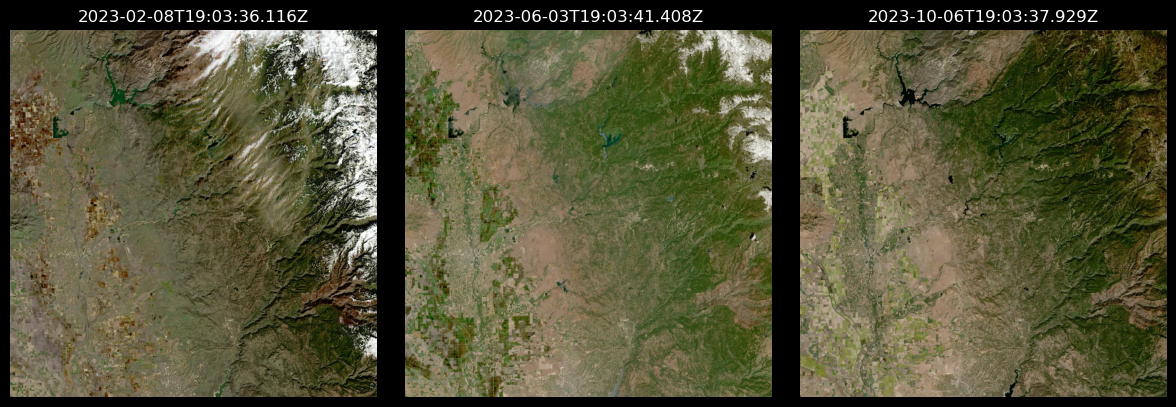

In [19]:
# Create and instance of a CMR STAC catalog
catalog = CMRSTACCatalog()

dates = ['2023-02', '2023-06', '2023-10']
final_items = []
for i, date in enumerate(dates):
    # Search for items of interest:
    items = catalog.search(bbox=map.bbox, start_date=f"{date}-01", end_date=f"{date}-31", 
                        limit=10)

    # Filter out cloudy images
    clear_items = []
    for item in items:
        if item.get("properties").get('eo:cloud_cover') < 50: # set your desired cloud cover threshold
            clear_items.append(item)

    if not clear_items:
        raise ValueError(f"No items with cloud cover less than 50% found for date {date}")

    if i == 0:
        # Select the item that covers the bbox the most
        clear_items.sort(key=lambda item: bbox_intersection_ratio(map.bbox, item.get('bbox')), reverse=True)
        final_items.append(clear_items[0])
    else:
        # Select the first item with the same collection and bbox as the one selected for the first date
        for item in clear_items:
            if item.get('collection') == final_items[0].get('collection') and item.get('bbox') == final_items[0].get('bbox'):
                final_items.append(item)
                found_item = True
                break

        if not found_item:
            raise ValueError(f"No items with the same collection and bbox as the first date found for date {date}")

# Display RGB images of all items in a single plot
catalog.display_rgb_images(final_items)

### Extracting HLS COGs from the Cloud

GDAL configurations set successfully.
Authentication to NASA Earthdata Login credentials set successfully.
GDAL configurations set successfully.
Authentication to NASA Earthdata Login credentials set successfully.
GDAL configurations set successfully.
Authentication to NASA Earthdata Login credentials set successfully.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/iker/mambaforge/envs/hls_data_project/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


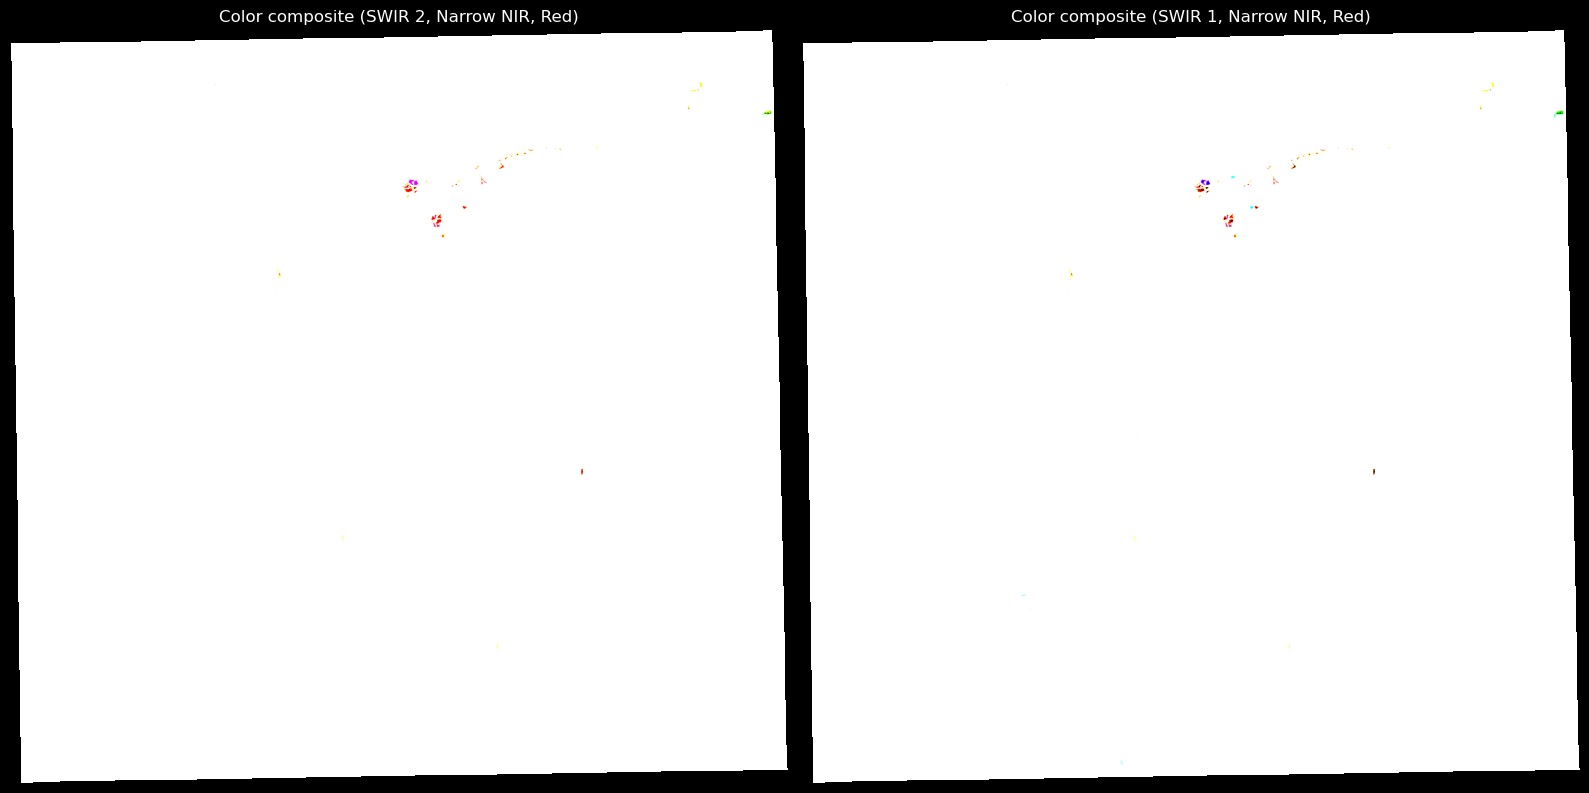

In [20]:
# Initialize an empty list to store input arrays
input_arrays = []

# Loop through all final_items
for item in final_items:
    # Initialize COGExtractor
    cog_extractor = COGExtractor(item, map.polygon)  

    # Get data
    band_data = cog_extractor.get_data()

    # Input array
    input_array = cog_extractor.get_input_array(band_data)

    # Append input array to the list
    input_arrays.append(input_array)

# Concatenate input arrays in the last dimension
stacked_input_arrays = np.concatenate(input_arrays, axis=-1)

# Display composites
cog_extractor.display_composites(band_data)

## Crop classification

In [47]:
config_path = "../Prithvi/configs/multi_temporal_crop_classification_Prithvi_100M_array.py"
ckpt = "../Prithvi/checkpoints/multi_temporal_crop_classification_Prithvi_100M.pth"
bands = "[0,1,2,3,4,5]"

# Initialize ModelProcessor
model_processor = ModelProcessor(config_path, ckpt, bands)

# Get prediction
mask = model_processor.predict(stacked_input_arrays[:800, :800, :])

# Display input/output
#model_processor.display_io(stacked_input_arrays, mask)


load checkpoint from local path: ../Prithvi/checkpoints/multi_temporal_crop_classification_Prithvi_100M.pth


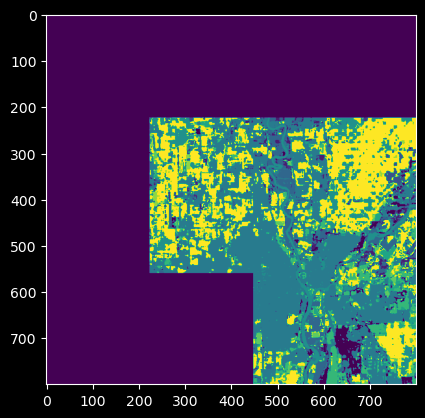

In [48]:
plt.imshow(mask)